#### Load required libraries

In [2]:
import numpy as np
import logging
import pickle
from scipy import sparse
from scipy.linalg import block_diag
import scipy.io as spio

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

import os
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/SH_AcO'
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'

In [3]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

<module 'dos.plot_tools' from '/Users/rromano/Workspace/SIMCEO/dos/plot_tools.py'>

In [4]:
# Reload DOS library
import importlib
importlib.reload(dos.tools)

<module 'dos.tools' from '/Users/rromano/Workspace/SIMCEO/dos/tools.py'>

#### Load Active Optics Influence Matrix

In [5]:
# Calibrations data
#dt = np.load(Path(calibDataFolder)/'calib_dt_SH0p5fluxTH_46BM.npz', allow_pickle=True)
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM.npz', allow_pickle=True)


In [6]:
# Relative RBM:BM sensitivity
norm_RBM = np.linalg.norm(dt['calibdt'][()]['D'][0][:,:12])
norm_BM = np.linalg.norm(dt['calibdt'][()]['D'][0][:,12:])
print('Ratio ||BM||/||RBM||:',norm_BM/norm_RBM)
# M1:M2 sensitivity
norm_Dm1 = np.linalg.norm(dt['calibdt'][()]['D'][0][:,:6])
norm_Dm2 = np.linalg.norm(dt['calibdt'][()]['D'][0][:,6:12])
print('Ratio ||D_m1||/||D_m2||:%0.3g'%(norm_Dm1/norm_Dm2))

Ratio ||BM||/||RBM||: 0.057479135047774646
Ratio ||D_m1||/||D_m2||:7.77


In [12]:
def get_aco_recW2(Dsh,wfsMask,rho_p,rho_s):
    n_bm = ((Dsh.shape[1]+2)//7) - 12
    if((Dsh.shape[1]+2) % 7):
            print('Unable to get the correct number of the calibrated bending modes. Check Dsh!')
    # - - - Global clocking filtering
    _U,sigma,VT = np.linalg.svd(Dsh,full_matrices=False)
    n_r = 12
    q = sigma[-n_r:]
    W2_clk = VT[-n_r:,:].T.dot(np.diag(q)).dot(VT[-n_r:,:])
    
    # - - - Segment piston penalization
    dt_p = np.load('/Users/rromano/Workspace/SIMCEO/calibration_dbs/piston_mount_calib_dt_GSH.npz', 
                 allow_pickle=True)
    Dp = dt_p['calibdt'][()]['Dp']
    # List of outer-axis piston inducing influence matrices
    Dp_list = [* np.split(Dp,np.arange(12,84,12),axis=1)]
    # Include zero columns corresponfing to bending modes 
    Dp1to6 = np.hstack([*[np.append(DpSeg,np.zeros((Dp.shape[0],n_bm)),axis=1) for DpSeg in Dp_list[:-1]]])
    Dp7 = np.append(np.delete(Dp_list[-1],[5,11],axis=1),np.zeros((Dp.shape[0],n_bm)),axis=1)
    DpwBM = np.hstack([Dp1to6,Dp7])
    W2_piston = DpwBM.T.dot(DpwBM)

    if(0):
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(8,4))
        plt.imshow(W2_piston[:12,:12],aspect='auto')
    
    # - - - Mean slope penalization
    O = np.kron(np.eye(6),np.ones((48*48,1)))
    Vs = np.zeros((Dsh.shape[0],6))
    for iv in range(6):
        Vs[:,iv] = np.hstack([*[O[MaskSeg.ravel(),iv] for MaskSeg in wfsMask]])
    Alpha = np.diag(1/np.sum(Vs,axis=0))
    # Matrix that computes mean slope of each probe
    
    S = np.matmul(Vs @ Alpha @ Vs.T, Dsh)
    W2_mslope = S.T.dot(S)
    
    W2 = W2_clk + rho_p*W2_piston + rho_s*W2_mslope
    Rs = np.eye(Dsh.shape[0]) - (Vs @ Alpha @ Vs.T)
    return W2, Rs


In [13]:
def get_aco_recW3(rho_rbm1,rho_rbm2,rho_Fz):
    
    W_M1TxyzRxyz = [rho_rbm1*i_cm for i_cm in [1]*6]
    W_M2TxyzRxyz = [rho_rbm2*i_cm for i_cm in [1]*6]
    
    W_rbm_oa = block_diag(np.diag(W_M1TxyzRxyz), np.diag(W_M2TxyzRxyz))
    W_rbm_cs = block_diag(np.diag(W_M1TxyzRxyz[:-1]), np.diag(W_M2TxyzRxyz[:-1]))
    
    # OA segment weights
    W_m1oaF = np.diag([1]*165)
    W_m1oaF =  rho_Fz*(1/np.linalg.norm(W_m1oaF))*W_m1oaF
    # CS (center segment) weights
    W_m1csF = np.diag([1]*154)
    W_m1csF =  rho_Fz*(1/np.linalg.norm(W_m1csF))*W_m1csF

    # Rescale RBM weighting matrix
    rbm_factor = 1/np.linalg.norm(W_rbm_oa) 
    # Merge weighting matrices
    W3_oa = block_diag(rbm_factor*W_rbm_oa,W_m1oaF)
    W3_cs = block_diag(rbm_factor*W_rbm_cs,W_m1csF)
    W3 = block_diag(np.kron(np.eye(6),W3_oa),W3_cs)
    
    W3 = (1/np.linalg.norm(W3))*W3
    
    return W3



#### AcO reconstructor+controller settings

In [14]:
# *** Reconstructor tuning settings ***

# Number of bending modes
n_bm = 27

# Consolidate SH-WFS interaction matrices of all segments
Dsh = block_diag(*[Dseg[:,:12+n_bm] for Dseg in dt['calibdt'][()]['D'][:-1]])
Dsh = block_diag(Dsh,dt['calibdt'][()]['D'][-1][:,:10+n_bm])

# Get weighting matrices
W2, Rs = get_aco_recW2(Dsh,dt['calibdt'][()]['wfsMask'],rho_p=1.0e-5,rho_s=1.0e-2)
W3 = get_aco_recW3(rho_rbm1=4, rho_rbm2=1, rho_Fz=0.1*(12/165)**2 )

rho_2, rho_3 = 1., 1.

if(1):
    # Print reconstructor regularization weights
    np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
    #aux = np.reshape(np.insert(np.diag(W3),[72+(n_bm*6)+5,72+(n_bm*6)+10],0),[7,12+n_bm])
    aux = np.insert(np.diag(W3),[72+(165*6)+5,72+(165*6)+10],0)
    aux = np.reshape(np.append(aux,np.array([0]*11)),[7,12+165])
    _wM1rbm,_wM2rbm,_wBM = np.split(aux,[6,12],axis=1)
    print('M1/TxyzRxyz weights:\n',_wM1rbm)
    print('\nM2/TxyzRxyz weights:\n',_wM2rbm)
    print('\nFz weights:\n',_wBM[0,:5],'...')

    np.set_printoptions(formatter=None)


# Bending modes' data
Afz = {}
# OA segment weights
filepath = os.path.join('../ActiveOptics','Af_oa_axial_ver3.mat')
Afz['outer'] = spio.loadmat(filepath)['afprime']
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
bm2Fz_oa = np.dot(V_oaT.T, np.diag(1/s_oa)[:,:n_bm])
# CS (center segment) weights
filepath = os.path.join('../ActiveOptics','Af_cs154_axial.mat')
Afz['center'] = spio.loadmat(filepath)['afprime']
_U,s_cs,V_csT = np.linalg.svd(Afz['center'],0)
bm2Fz_cs = np.dot(V_csT.T, np.diag(1/s_cs)[:,:n_bm])


# Max actuator command values
max_m1RBM = [3.0e-3,4.75e-3,4e-3] + [6.5e-4,5.75e-4,5.75e-4]
max_m2RBM = [3.0e-5,3.0e-5,3.0e-5] + [3.5e-3,3.5e-3,3.5e-3]

max_Fz = 147
fz_factor = np.mean(max_m1RBM + max_m2RBM)/max_Fz

rbm_ranges = max_m1RBM+max_m2RBM
oa_ranges = np.array(rbm_ranges + [fz_factor*max_Fz]*bm2Fz_oa.shape[0])
cs_ranges = np.array(rbm_ranges + [fz_factor*max_Fz]*bm2Fz_cs.shape[0])
#oa_ranges = np.array(rbm_ranges + [max_Fz]*bm2Fz_oa.shape[0])
#cs_ranges = np.array(rbm_ranges + [max_Fz]*bm2Fz_cs.shape[0])

umax = np.hstack([np.kron(np.array([1]*6),oa_ranges),cs_ranges]) # np.array([]) #
umin = -umax
_Tu = block_diag(np.kron(np.eye(6),block_diag(np.eye(12),fz_factor*bm2Fz_oa)),
                 block_diag(np.eye(12),fz_factor*bm2Fz_cs))
_TuwoS7Rz = block_diag(np.kron(np.eye(6),block_diag(np.eye(12),fz_factor*bm2Fz_oa)),
                 block_diag(np.eye(10),fz_factor*bm2Fz_cs))

# AcO integral controller gain
K = 0.25

# AcO dictionary
W3 = _TuwoS7Rz.T @ W3 @ _TuwoS7Rz
data = {'SHAcO_qp':{'D':Dsh,'n_bm':n_bm,
                    'W2':W2,'W3':W3,'K':K,'rho_2':rho_2,'rho_3':rho_3,
                    'wfsMask':dt['calibdt'][()]['wfsMask'],
                    'umin':umin, 'umax':umax,'_Tu':_Tu,'Rs':Rs,'J1_J3_ratio':100}}
# Pickles MPC data into string representation
with open(Path(sim_folder)/'SHAcO_qp.pickle','wb') as f:
    pickle.dump(data,f)
    

M1/TxyzRxyz weights:
 [[ 0.151511  0.151511  0.151511  0.151511  0.151511  0.151511]
 [ 0.151511  0.151511  0.151511  0.151511  0.151511  0.151511]
 [ 0.151511  0.151511  0.151511  0.151511  0.151511  0.151511]
 [ 0.151511  0.151511  0.151511  0.151511  0.151511  0.151511]
 [ 0.151511  0.151511  0.151511  0.151511  0.151511  0.151511]
 [ 0.151511  0.151511  0.151511  0.151511  0.151511  0.151511]
 [ 0.151511  0.151511  0.151511  0.151511  0.151511  0.000000]]

M2/TxyzRxyz weights:
 [[ 0.037878  0.037878  0.037878  0.037878  0.037878  0.037878]
 [ 0.037878  0.037878  0.037878  0.037878  0.037878  0.037878]
 [ 0.037878  0.037878  0.037878  0.037878  0.037878  0.037878]
 [ 0.037878  0.037878  0.037878  0.037878  0.037878  0.037878]
 [ 0.037878  0.037878  0.037878  0.037878  0.037878  0.037878]
 [ 0.037878  0.037878  0.037878  0.037878  0.037878  0.037878]
 [ 0.037878  0.037878  0.037878  0.037878  0.037878  0.000000]]

Fz weights:
 [ 0.000016  0.000016  0.000016  0.000016  0.000016] ...


In [8]:
Ds = Rs.dot(Dsh)
condDTD = np.linalg.cond(Ds.T.dot(Ds))
print('Condition number imovement due to W2:',condDTD/np.linalg.cond(Ds.T.dot(Ds)+rho_2*W2))
print('Condition number imovement due to W2 and W3:',condDTD/np.linalg.cond(Ds.T.dot(Ds)+W2+1.0e-6*K*W3*K))

Condition number imovement due to W2: 2154.404876629159
Condition number imovement due to W2 and W3: 3233.7184330849673


In [58]:
condDTD = np.linalg.cond(Dsh.T.dot(Dsh))
print('Condition number imovement due to W2:',condDTD/np.linalg.cond(Dsh.T.dot(Dsh)+rho_2*W2))
print('Condition number imovement due to W2 and W3:',condDTD/np.linalg.cond(Dsh.T.dot(Dsh)+W2+1.0e-6*K*W3*K))

Condition number imovement due to W2: 1784.7524320561904
Condition number imovement due to W2 and W3: 2863.450675347667


In [9]:
uD,sD,vDT = np.linalg.svd(Dsh,full_matrices=False)
print('Weakest singular values :\n',sD[-15:])


Weakest singular values :
 [1.03913686e-04 9.70721974e-05 9.62937697e-05 6.02657673e-05
 6.02291342e-05 7.87720578e-06 7.63380216e-06 6.57955850e-06
 6.55840959e-06 3.41342174e-06 3.33077288e-06 2.77936388e-06
 2.62557693e-06 2.45440939e-06 2.28006589e-06]


#### Get initial M1/M2 states and generate respective yaml files

In [9]:
# Python code to set simulation states
from ruamel import yaml
from ruamel.yaml import YAML
m1m2load_folder = 'testDT/M1M2_loads'
r_id = 1

test_case = 'random' # 'random_RBM' # 'BM_dist' #

if(test_case == 'BM_dist'):
    fileSTR = '_2_3bm'
elif(test_case == 'random_RBM'):
    fileSTR = '_rand_rbm_%d' %r_id
elif(test_case == 'random'):
    fileSTR = '_rbmplusbm_%d' %r_id
else:
    fileSTR = '_noload' %r_id

print(fileSTR)

with open(Path(m1m2load_folder)/('M1'+fileSTR+'.yaml'),'r') as f:
    m1_x0_dt = yaml.safe_load(f)
with open(Path(m1m2load_folder)/('M2'+fileSTR+'.yaml'),'r') as f:
    m2_x0_dt = yaml.safe_load(f)
   
 
# Update yaml files with M1/M2 initial conditions    
with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)
    

_rbmplusbm_1


#### Instantiate DOS

In [10]:
sim = dos.DOS(sim_folder,verbose=logging.WARNING,show_timing=2)

INFO:wfs48 data:Linked to data from wfs48
INFO:M1 Txyz:Linked to Txyz from M1
INFO:M1 Rxyz:Linked to Rxyz from M1
INFO:M2 Txyz:Linked to Txyz from M2
INFO:M2 Rxyz:Linked to Rxyz from M2
INFO:M1 BM:Linked to modes from M1


SIMCEO server received: Acknowledging connection from SIMCEO client!


In [11]:
# Start simulation
#sim.start()
sim._run_()

-> J1:4.72e-10, J3:6.32e-11, ratio:7.48, ||s||:1.74e-08
+> J1:4.54e-10, J3:1.16e-10, ratio:52.4, rho_3:0.0748
-> J1:4.54e-10, J3:4.41e-10, ratio:13.8, ||s||:1.73e-08
+> J1:4.53e-10, J3:4.85e-10, ratio:90.8, rho_3:0.0103
-> J1:4.55e-10, J3:9.22e-10, ratio:47.9, ||s||:9.79e-09
+> J1:4.55e-10, J3:9.32e-10, ratio:98.9, rho_3:0.00493
-> J1:4.55e-10, J3:1.3e-09, ratio:70.8, ||s||:4.43e-09
+> J1:4.55e-10, J3:1.31e-09, ratio:99.7, rho_3:0.00349
-> J1:4.54e-10, J3:1.56e-09, ratio:83.1, ||s||:1.92e-09
+> J1:4.54e-10, J3:1.57e-09, ratio:99.9, rho_3:0.0029
-> J1:4.54e-10, J3:1.72e-09, ratio:90.7, ||s||:9.37e-10
+> J1:4.54e-10, J3:1.73e-09, ratio:99.9, rho_3:0.00263
-> J1:4.53e-10, J3:1.82e-09, ratio:94.8, ||s||:6.01e-10
+> J1:4.53e-10, J3:1.82e-09, ratio:100, rho_3:0.00249
-> J1:4.53e-10, J3:1.87e-09, ratio:97.3, ||s||:4.95e-10
+> J1:4.53e-10, J3:1.87e-09, ratio:100, rho_3:0.00243
-> J1:4.53e-10, J3:1.89e-09, ratio:98.5, ||s||:4.64e-10
+> J1:4.53e-10, J3:1.89e-09, ratio:100, rho_3:0.00239
-> J1:4.

In [32]:
sim.pctComplete

100

### Image quality metrics

In [13]:
sim.logs

The 'logs' has 12 entries:
 * wfs48
   1. M12_RBM: (273,)x50
 * SHAcO_qp
   1. M1 Txyz: (7, 3)x50
   2. M1 Rxyz: (7, 3)x50
   3. M2 Txyz: (7, 3)x50
   4. M2 Rxyz: (7, 3)x50
   5. M1 BM: (7, 27)x50
 * science
   1. wfe_rms: (1,)x50
   2. segment_wfe_rms: (7,)x50
   3. PSSn: (1,)x50
   4. tiptilt: (2,)x50
   5. segment_piston: (7,)x50
   6. segment_tiptilt: (14,)x50

In [14]:
print(sim.logs.entries['science']['wfe_rms'].timeSeries[1][0,:]*1.0e9)
print('Seg WFE RMS:\n',sim.logs.entries['science']['segment_wfe_rms'].timeSeries[1][0,:]*1.0e9)

[5916.89877183]
Seg WFE RMS:
 [2039.7001208  4239.04884883 2914.79432235 3886.75107388 3892.09571949
 3626.94277101 4308.13997809]


#### GS = 6 : (Random) RBM load test


Final values:
 WFE (nm): [11.47495698] 
 [0.4883649  0.96594999 0.58798105 0.61259581 0.98225095 0.59114957
 0.39618331] 
PSSn: [0.99999998] 
sum of abs seg piston (um): 0.06316121835270305 
 [ 0.02366447 -0.00239964  0.0040662   0.01239444  0.00012321 -0.00620415
 -0.01430911]


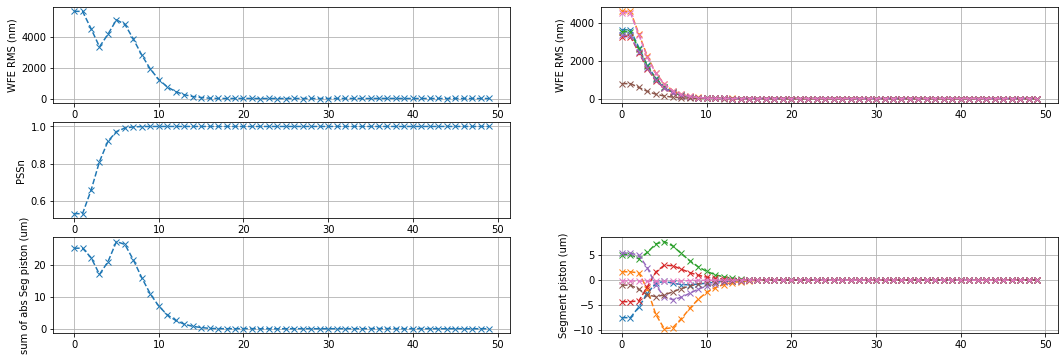

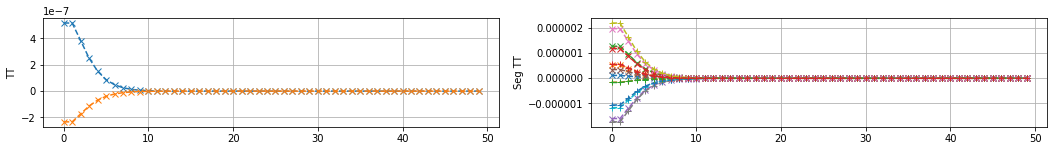

In [56]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

#### GS = 6 : Bending mode load test


Final values:
 WFE (nm): [121.24718296] 
 [4.39167636 0.78200663 0.76656648 0.76562712 0.77716134 0.78222806
 0.17492878] 
PSSn: [1.00006994] 
sum of abs seg piston (um): 0.3751798882678514 
 [ 3.42417309e-01 -8.39151582e-04  2.06937645e-03  1.02257438e-02
 -1.14515342e-04 -5.25820809e-03 -1.42555843e-02]


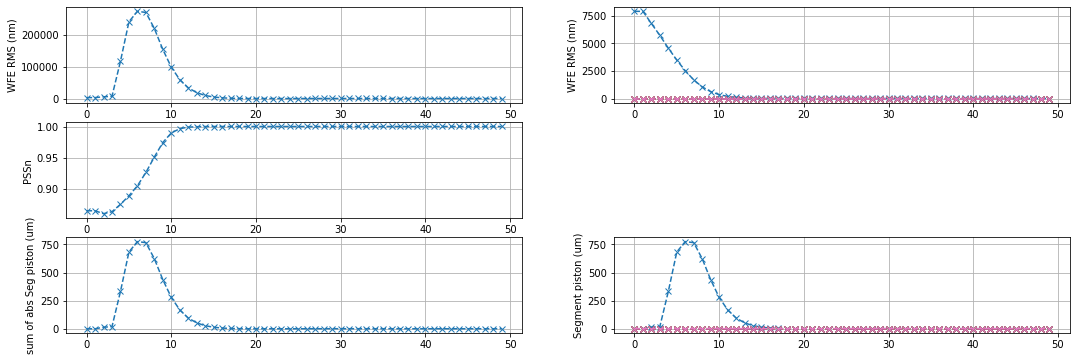

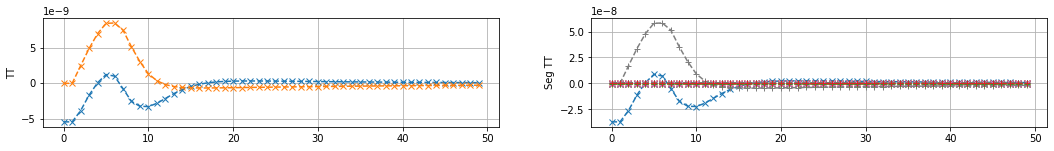

In [61]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

#### GS = 14: (Random) RBM load test


Final values:
 WFE (nm): [438.68462285] 
 [0.7979914  0.81523088 0.56154104 0.80415952 0.89064578 0.68444839
 0.77493534] 
PSSn: [1.00003498] 
sum of abs seg piston (um): 2.6666230175109717 
 [ 0.62948016 -0.18770737 -0.01139258  0.04414601  0.97125712  0.48739423
 -0.33524555]


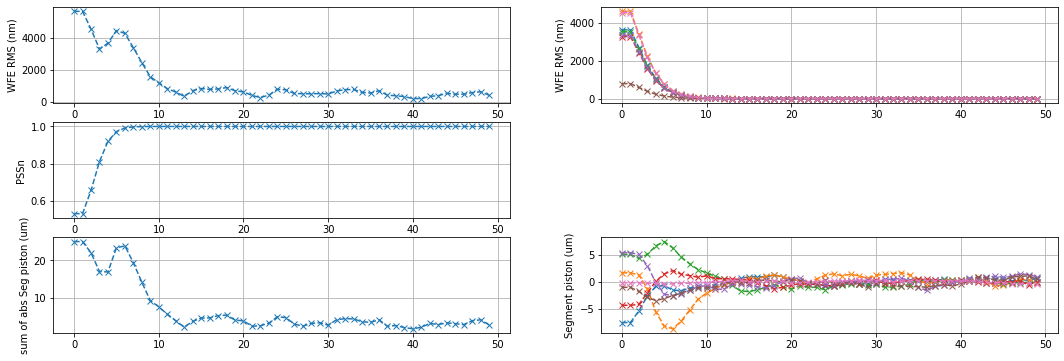

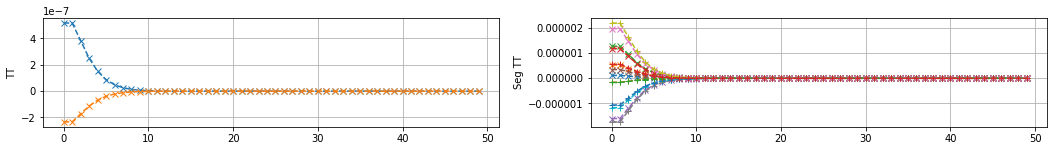

In [45]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

#### GS = 14 : Bending mode load test


Final values:
 WFE (nm): [662.5564879] 
 [2.44741694 0.73137224 0.59564448 0.83678253 0.99797626 0.66648964
 0.81519624] 
PSSn: [1.00003491] 
sum of abs seg piston (um): 4.289013673997033 
 [ 0.57424154 -1.10413805 -0.31721493  0.4035993   0.80915567  0.73715808
 -0.34350612]


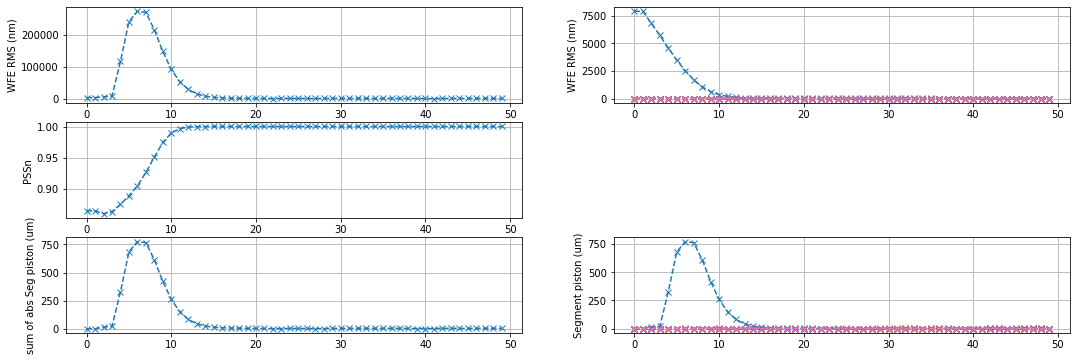

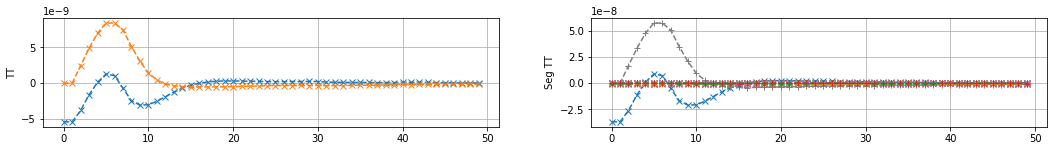

In [26]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

#### BM + RBM load test


Final values:
 WFE (nm): [508.44130328] 
 [7.08431314 0.77352752 0.75588169 0.73535433 0.53006299 0.53484778
 0.83349089] 
PSSn: [1.00006954] 
sum of abs seg piston (um): 3.161533385309667 
 [-0.39713927 -0.26422214  0.14280602  0.23945779  0.90475083  0.87237089
 -0.34078644]


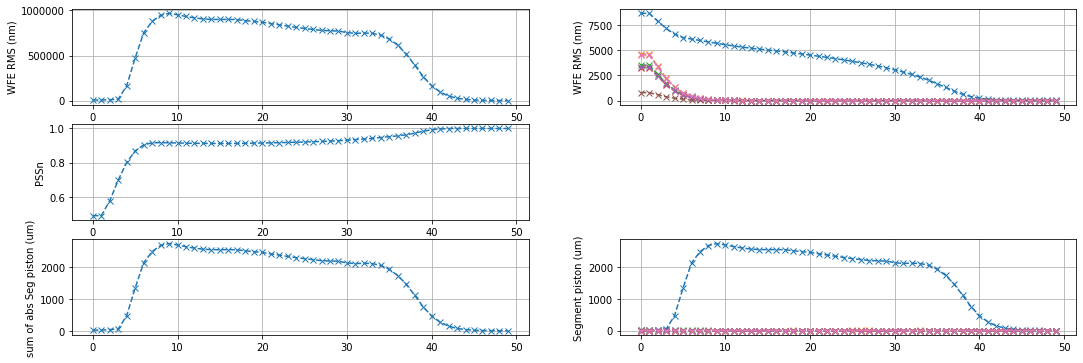

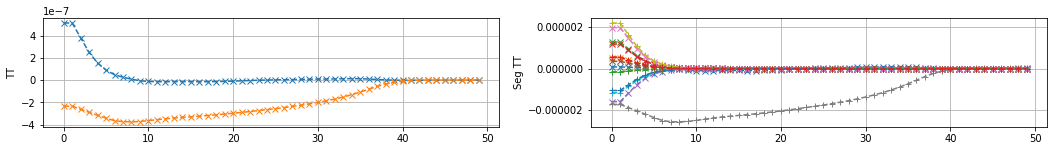

In [50]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])


Final values:
 WFE (nm): [2675.453743] 
 [2.6205369  2.4430673  2.35378161 1.85091309 2.23460006 2.30752639
 1.89726812] 
PSSn: [0.9999974] 
sum of abs seg piston (um): 13.228822425048747 
 [ 1.32847333 -1.37275629  7.10820996  1.21889616  0.7616801  -1.3477121
  0.09109449]


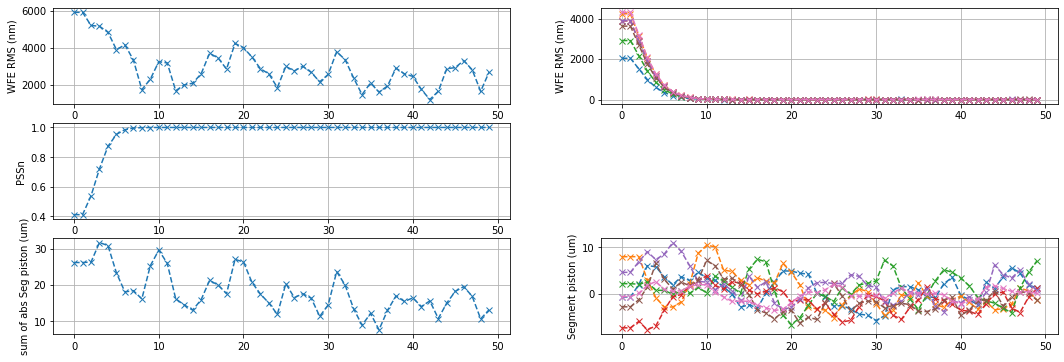

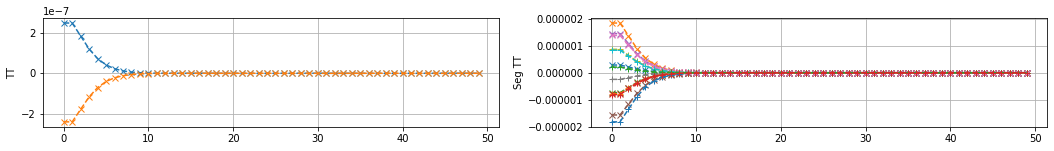

In [23]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])


Final values:
 WFE (nm): [3250.22324432] 
 [700.53221179 705.17461381 691.34398473 698.31952487 707.93981877
 689.36481057 739.45886925] 
PSSn: [0.99999693] 
sum of abs seg piston (um): 18.98661281529712 
 [-1.662258    3.06071297  0.87308746 -5.4117545   1.91497588 -5.27214388
  0.79168012]


(<Figure size 864x432 with 5 Axes>, <Figure size 864x144 with 2 Axes>)

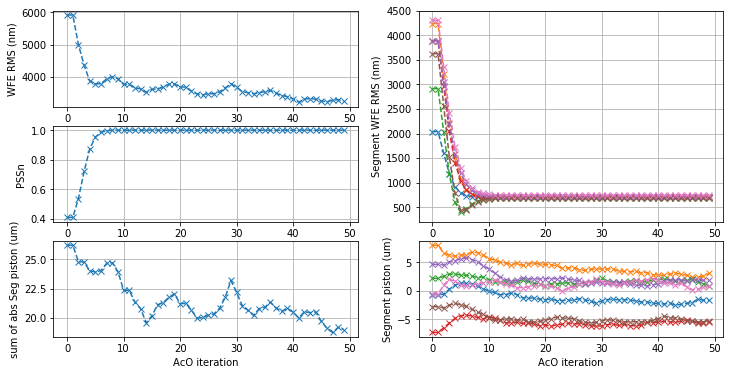

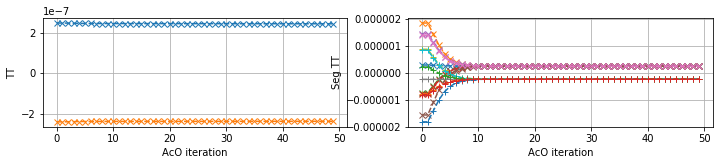

In [12]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

### Controller outputs and aberration inducing loads

#### GS = 6 : (Random) RBM load test

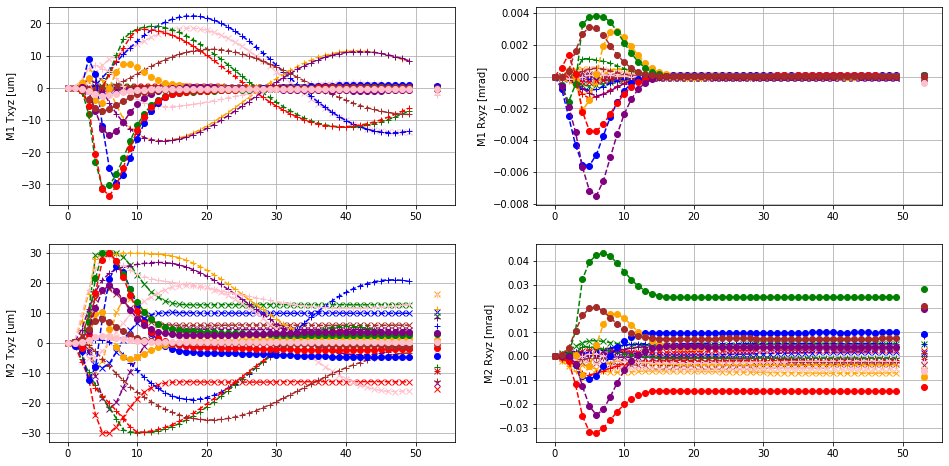

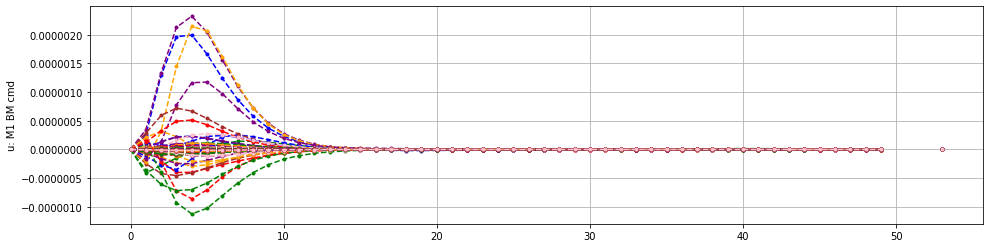

In [57]:
U = sim.logs.entries['SHAcO_qp']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers, rm_samples=0)

#### GS = 6 : Bending mode load test

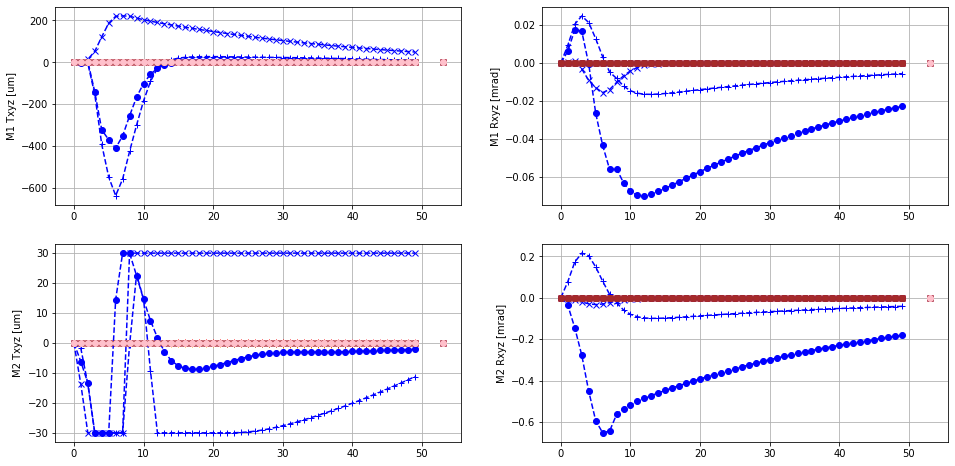

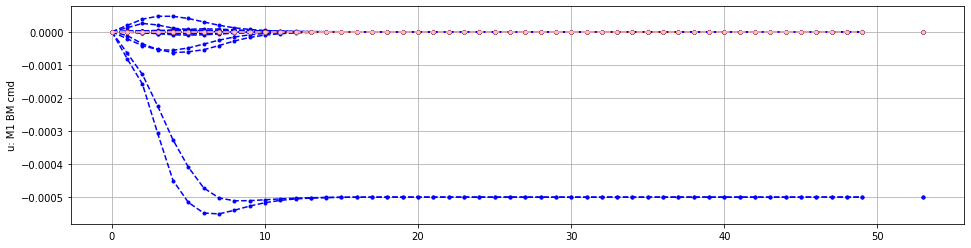

In [62]:
U = sim.logs.entries['SHAcO_qp']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### GS = 14 : (Random) RBM load test

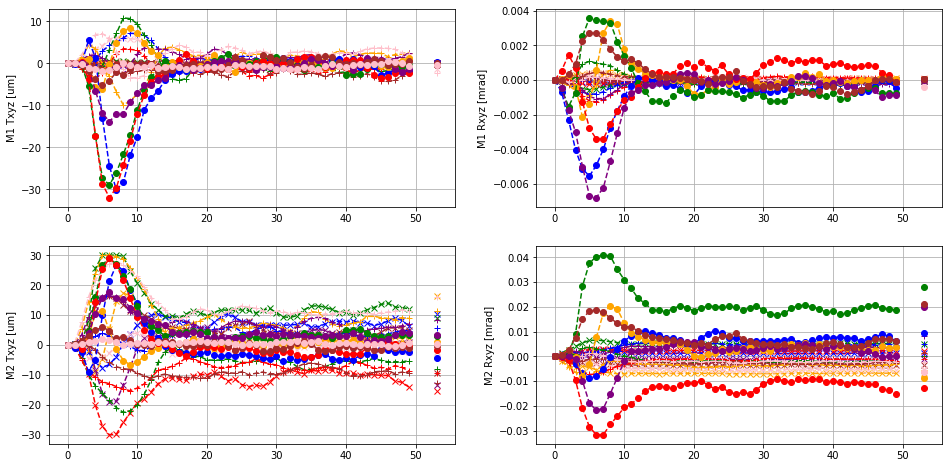

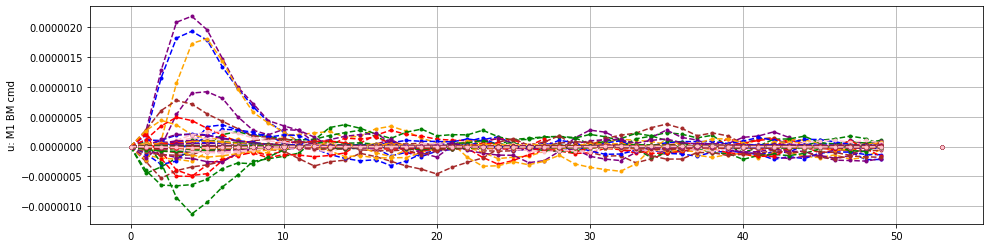

In [46]:
U = sim.logs.entries['SHAcO_qp']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers, rm_samples=0)

#### GS = 14 : Bending mode load test

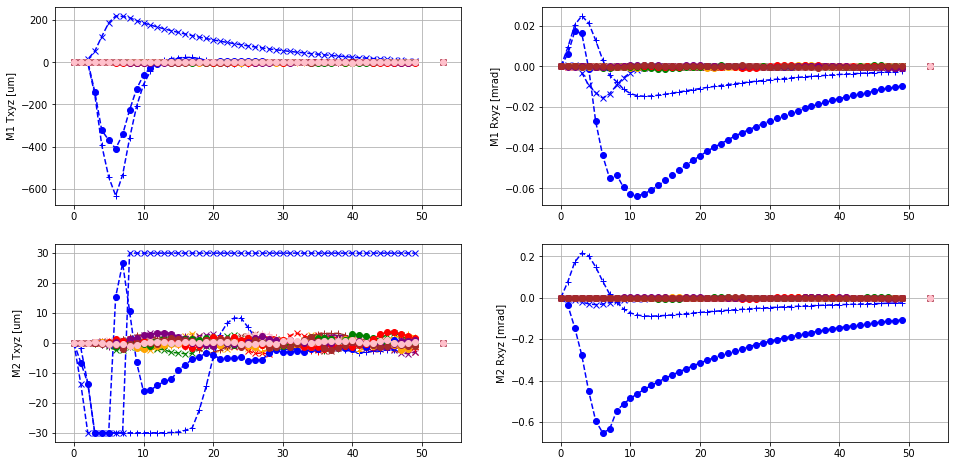

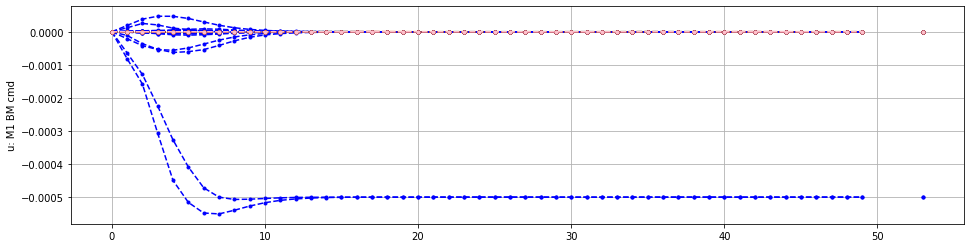

In [27]:
U = sim.logs.entries['SHAcO_qp']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers, rm_samples=0)

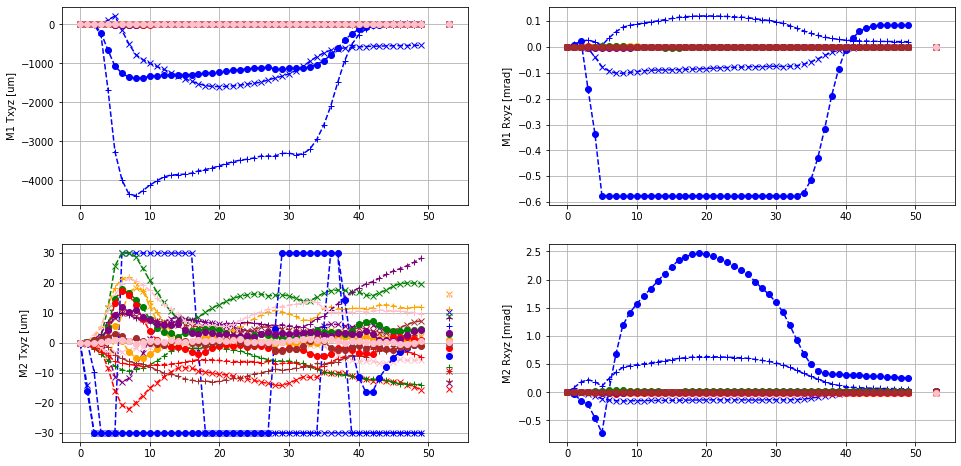

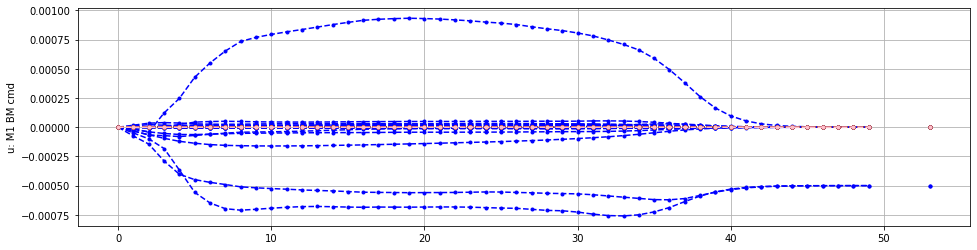

In [51]:
U = sim.logs.entries['SHAcO_qp']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

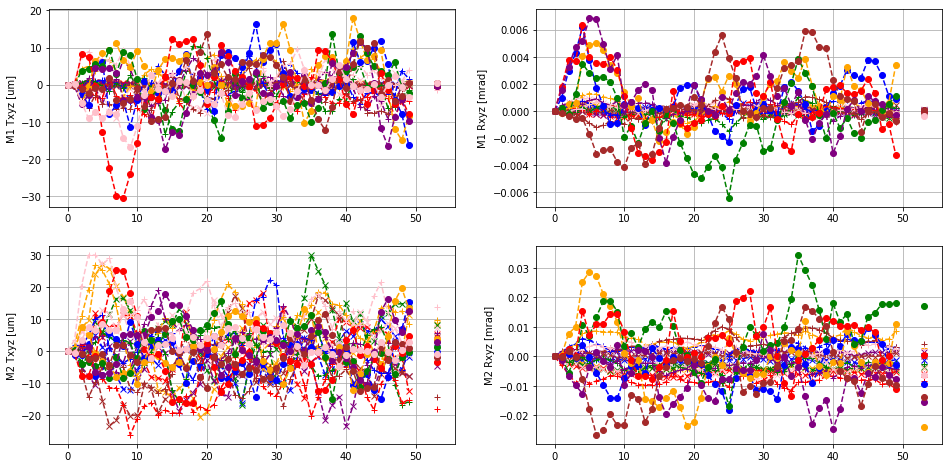

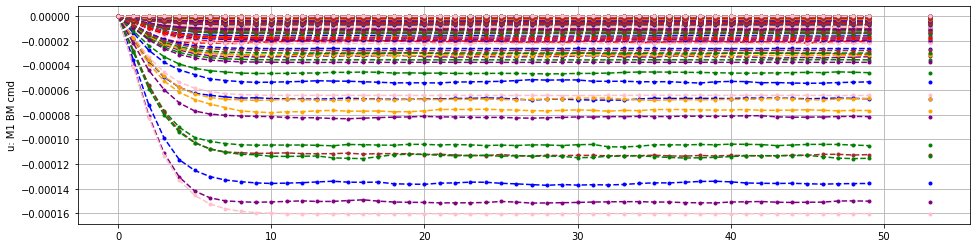

In [25]:
U = sim.logs.entries['SHAcO_qp']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

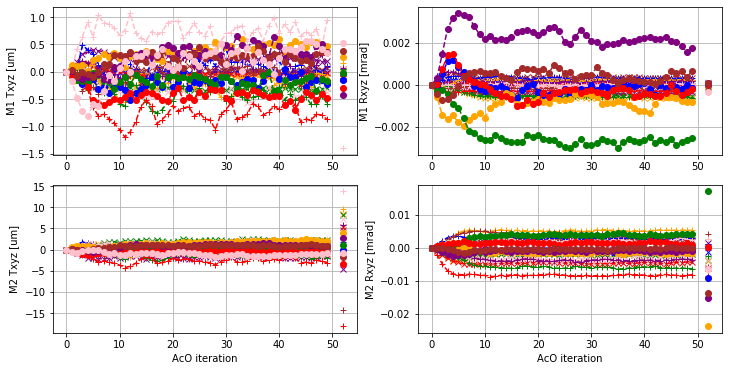

(<Figure size 864x432 with 4 Axes>, <Figure size 864x144 with 1 Axes>)

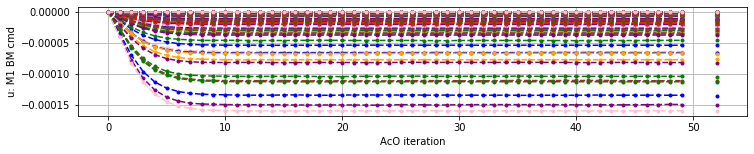

In [13]:
U = sim.logs.entries['SHAcO_qp']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

In [11]:
import scipy.io
if 'CG2HP' not in locals():
    CG2HP = scipy.io.loadmat('../ActiveOptics/CG2HP.mat')

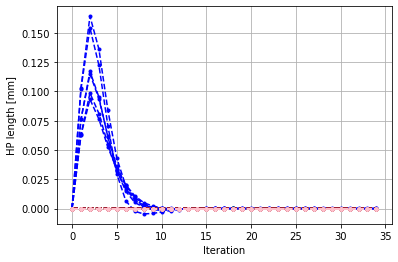

In [12]:
U = sim.logs.entries['SHAcO']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

In [79]:
3.5e-6*(180/np.pi)*3600

0.7219268218648373

In [103]:
# Test cases in which REQ-L4-M1S-51833 seems misleading, according 
#to the CG2HP matrix of build3 fem
M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,650e-6,575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,0*650e-6,0*575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

HP lengths [ 6.15074717  2.42595625  2.38654281  5.98007822  3.34834477 -3.78004005]
HP lengths [ 7.96706706  2.71784883  1.4437542   4.29725283  2.50323777 -2.38093131]


In [98]:
np.array([[0.38, 40],[3, 330]])/3600*(np.pi/180)

array([[1.84229199e-06, 1.93925472e-04],
       [1.45444104e-05, 1.59988515e-03]])

### Actuator force test

#### GS = 6 : Bending mode load test

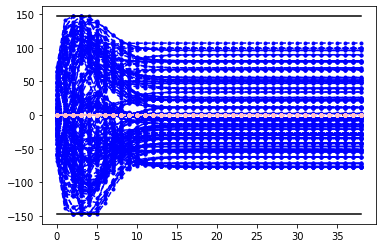

In [12]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO_qp']['M1 BM'].timeSeries
k_max = 40

for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,1:k_max]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,1:k_max]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0][1:k_max].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0][1:k_max].shape),'k')
plt.show()

#### GS = 14 : Bending mode load test

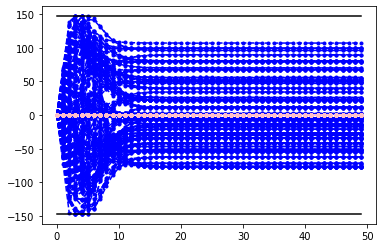

In [48]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO_qp']['M1 BM'].timeSeries
for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,:]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,:]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0].shape),'k')
plt.show()

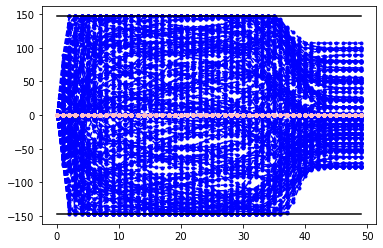

In [52]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO_qp']['M1 BM'].timeSeries
for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,:]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,:]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0].shape),'k')
plt.show()

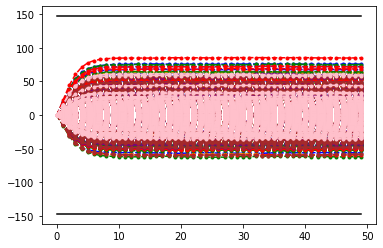

In [24]:
import matplotlib.pyplot as plt

BM_ = sim.logs.entries['SHAcO_qp']['M1 BM'].timeSeries
for kseg in range(6):
    plt.plot(bm2Fz_oa.dot(BM_[1][kseg,:,:]).T,'--.',color=colors[kseg])
plt.plot(bm2Fz_cs.dot(BM_[1][6,:,:]).T,'--.',color=colors[6])
plt.plot(max_Fz*np.ones(BM_[0].shape),'k')
plt.plot(-max_Fz*np.ones(BM_[0].shape),'k')
plt.show()

In [91]:
#U_sat.shape, Fz2bm.shape, bm_sat.shape
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
isigma = np.zeros_like(s_oa)
n_bm = 27
isigma[:n_bm] = 1/s_oa[:n_bm]

T1 = np.dot(V_oaT.T, np.diag(isigma))
T2 = np.dot(np.diag(s_oa),V_oaT)
print('norm of I-T1*T2: %0.4g'%np.linalg.norm(np.eye(165)-T1.dot(T2)))

U_ = bm2Fz_oa.dot(BM_[1][0,:,4])
U_sat = np.clip(U_, -np.array([max_Fz]*bm2Fz_oa.shape[0]), np.array([max_Fz]*bm2Fz_oa.shape[0]))
bm_sat = T2.dot(U_sat)
bm_sat_reg = np.zeros_like(s_oa)
bm_sat_reg[:n_bm] = bm_sat[:n_bm]
max(U_sat), max(U_), max(T1.dot(bm_sat))

norm of I-T1*T2: 11.75


(147.0, 172.9410106583431, 160.85400194782264)

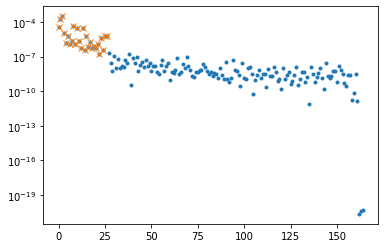

In [92]:
plt.semilogy(np.abs(bm_sat),'.')
plt.semilogy(np.abs(bm_sat_reg),'x')


Final values:
 WFE (nm): [1.61779912] 
 [0.77301304 0.79976392 0.71529371 0.76740836 0.78733225 0.60649952
 0.18290831] 
PSSn: [0.99999985] 
sum of abs seg piston (um): 0.00823385323811543 
 [-0.00214022  0.00046747  0.0016916  -0.00065099 -0.0002844   0.00256101
 -0.00043816]


(<Figure size 864x432 with 5 Axes>, <Figure size 864x144 with 2 Axes>)

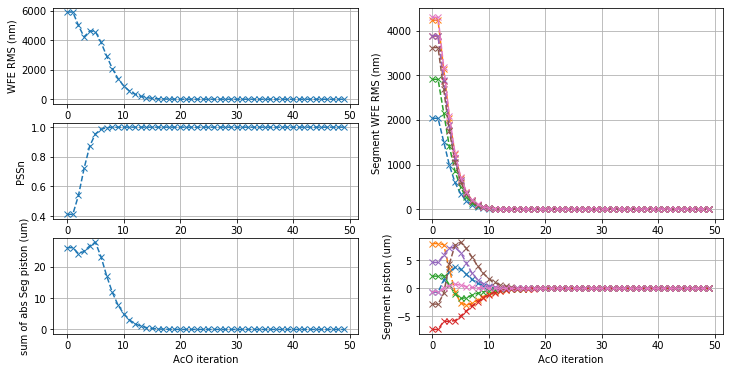

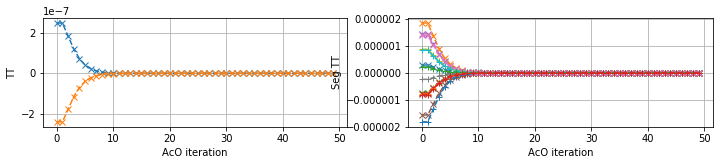

In [11]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])